In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial
plt.rcParams.update({'font.size': 18})
import matplotlib

In [305]:
from scipy import stats
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    if type(ind) == pd.core.series.Series : 
        N = ind.sum()
    else: 
        N = ind.shape
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(N), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p


In [65]:
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)
paired_df = paired_df[paired_df['Urban distance'] < 0.25]

In [200]:
cities = paired_df.index
stations = pd.read_table('data/synopticclassification/stations.txt', sep = ',')
#!mkdir plots/version6/ssc/
results_filepath = 'plots/version6/ssc/'
cols = ['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP', 'Dry versus Moist p-value']
# resultsDF = pd.DataFrame(np.ones([len(cities), 7])*np.nan, index = cities, 
#                          columns=['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP'])
# cities = ['Hartford',  'New York',  'Baltimore',  'Philadelphia', 
#              #'Washington, D.C.', 'Richmond','Norfolk',
#              #'Providence',  'Buffalo', 'Pittsburgh',
#             ]
UHI_resultsDF = pd.DataFrame(np.ones([len(cities), len(cols)])*np.nan, index = cities, 
                          columns=cols)
urban_resultsDF = pd.DataFrame(np.ones([len(cities), len(cols)])*np.nan, index = cities, 
                          columns=cols)
rural_resultsDF = pd.DataFrame(np.ones([len(cities), len(cols)])*np.nan, index = cities, 
                          columns=cols)
for city in paired_df.index: # cities[66:]: #paired_df.iloc[66:].index: #paired_df.index: 
#city = 'Washington'
    print(city)
    ssc_code = stations[stations['Station'].str.contains(city)]['ID'].values
    if city == 'Washington, D.C.': 
        ssc_code = np.array(['IAD'])
    if ssc_code.shape[0] > 0: 
        file = filepath + ssc_code[0] + '.dbdmt'
        synopticDF =  pd.read_table(file, sep = ' ', header =  None)
        synopticDF.columns = ['id','date', 'ssc']
        synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
        synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
        synopticDF = synopticDF.loc['2000-06-01':]

        urbanID = paired_df.loc[city]['Urban station']
        ruralID = paired_df.loc[city]['Rural station']
        # Downloadd from NCDC the station data, using the station ID listed in station list
        urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                             as_dataframe=True, update = False)
        ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                             as_dataframe=True, update = False)
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2000-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2000-01-01':].value/10.) 
        # clean data: eliminate data with flags     
        rural_tmin[~ruraldata['TMIN']['qflag'].isnull()] = np.nan
        urban_tmin[~urbandata['TMIN']['qflag'].isnull()] = np.nan

        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

        # clean data: eliminate min temperatures below 4 or above 35
#         rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#         urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]


        #calculate UHI
        UHI = urban_summer - rural_summer

        #mean_UHI_dry_ssc = UHI[synopticDF['ssc'][synopticDF['ssc']<3].index].mean()
        #mean_UHI_wet_ssc = UHI[synopticDF['ssc'][(synopticDF['ssc']>=4) & (synopticDF['ssc']<6)].index].mean()
        UHI_resultsDF.loc[city, ['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP']] = [UHI[synopticDF['ssc']==1].mean(), 
                               UHI[synopticDF['ssc']==2].mean(), 
                               UHI[synopticDF['ssc']==3].mean(), 
                               UHI[synopticDF['ssc']==4].mean(),
                               UHI[synopticDF['ssc']==5].mean(),
                               UHI[synopticDF['ssc']==6].mean(), 
                               UHI[synopticDF['ssc']==6.5].mean(),
                               ]
        UHI_resultsDF.loc[city, 'Dry versus Moist p-value'] = scipy.stats.ttest_ind(UHI[synopticDF['ssc'] <=3].dropna(),
                      UHI[synopticDF['ssc'] >3].dropna())[1]
        
        urban_resultsDF.loc[city, ['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP']] = [urban_summer[synopticDF['ssc']==1].mean(), 
                               urban_summer[synopticDF['ssc']==2].mean(), 
                               urban_summer[synopticDF['ssc']==3].mean(), 
                               urban_summer[synopticDF['ssc']==4].mean(),
                               urban_summer[synopticDF['ssc']==5].mean(),
                               urban_summer[synopticDF['ssc']==6].mean(), 
                               urban_summer[synopticDF['ssc']==6.5].mean(), 
        ]
        urban_resultsDF.loc[city, 'Dry versus Moist p-value'] = scipy.stats.ttest_ind(urban_summer[synopticDF['ssc'] <=3].dropna(),
                      urban_summer[synopticDF['ssc'] >3].dropna())[1]

        rural_resultsDF.loc[city, ['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP']] = [rural_summer[synopticDF['ssc']==1].mean(), 
                               rural_summer[synopticDF['ssc']==2].mean(), 
                               rural_summer[synopticDF['ssc']==3].mean(), 
                               rural_summer[synopticDF['ssc']==4].mean(),
                               rural_summer[synopticDF['ssc']==5].mean(),
                               rural_summer[synopticDF['ssc']==6].mean(), 
                               rural_summer[synopticDF['ssc']==6.5].mean(), 
        ]
        rural_resultsDF.loc[city, 'Dry versus Moist p-value'] = scipy.stats.ttest_ind(rural_summer[synopticDF['ssc'] <=3].dropna(),
                      rural_summer[synopticDF['ssc'] >3].dropna())[1]

        UHI_resultsDF.to_csv(results_filepath+'sscanalysis.csv')
        urban_resultsDF.to_csv(results_filepath+'urban_sscanalysis.csv')
        rural_resultsDF.to_csv(results_filepath+'rural_sscanalysis.csv')

    else: 
        print('No synoptic station for %s'%city)
resultsDF['Dry'] = resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
resultsDF['Moist'] = resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
resultsDF.to_csv(results_filepath+'UHI_sscanalysis.csv')

urban_resultsDF['Dry'] = urban_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
urban_resultsDF['Moist'] = urban_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
urban_resultsDF.to_csv(results_filepath+'urban_sscanalysis.csv')

rural_resultsDF['Dry'] = rural_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
rural_resultsDF['Moist'] = rural_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
rural_resultsDF.to_csv(results_filepath+'rural_sscanalysis.csv')

Mesa
No synoptic station for Mesa
Grand Prairie
No synoptic station for Grand Prairie
Irvine
No synoptic station for Irvine
New Haven
No synoptic station for New Haven
Fort Lauderdale
No synoptic station for Fort Lauderdale
Long Beach
No synoptic station for Long Beach
Hartford
Providence
Birmingham
St. Petersburg
No synoptic station for St. Petersburg
Virginia Beach
No synoptic station for Virginia Beach
Oakland
West Palm Beach
Louisville
Charlotte
Columbus
San Bernardino
No synoptic station for San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
No synoptic station for Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Philadelphia
Detroit
San Francisco
Denver
Houston
Miami
Atlanta
C

NameError: name 'urban_results' is not defined

In [308]:
results_filepath = 'plots/version6/ssc/'
ind = paired_df[paired_df['Urban distance']<.25].index
UHI_resultsDF   = pd.read_csv(results_filepath+'sscanalysis.csv').set_index('City').loc[ind]
urban_resultsDF = pd.read_csv(results_filepath+'urban_sscanalysis.csv').set_index('City').loc[ind]
rural_resultsDF = pd.read_csv(results_filepath+'rural_sscanalysis.csv').set_index('City').loc[ind]

In [309]:
urban_resultsDF['Dry'] = urban_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
urban_resultsDF['Moist'] = urban_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
rural_resultsDF['Dry'] = rural_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
rural_resultsDF['Moist'] = rural_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
UHI_resultsDF['Dry'] = UHI_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
UHI_resultsDF['Moist'] = UHI_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)

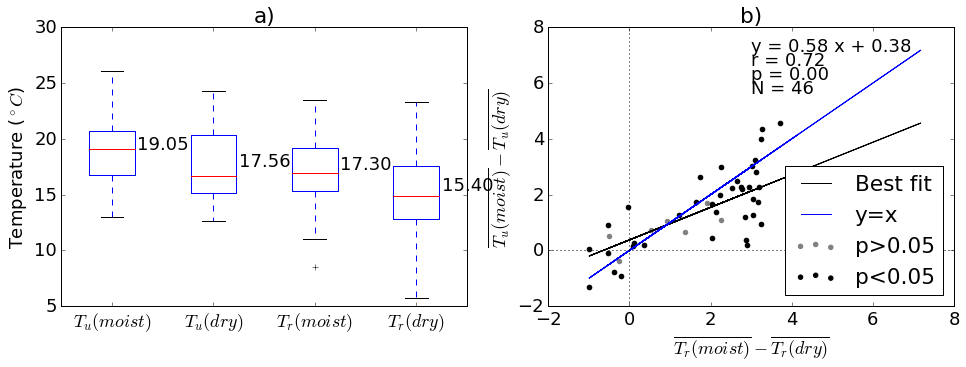

In [368]:
fig = plt.figure(figsize = [16,5])
ax = plt.subplot(121)
data = [urban_resultsDF['Moist'].dropna(), urban_resultsDF['Dry'].dropna(), 
        rural_resultsDF['Moist'].dropna(),  rural_resultsDF['Dry'].dropna(), 
       #UHI_resultsDF['Moist'].dropna(), UHI_resultsDF['Dry'].dropna(),
       ]
dict = plt.boxplot(data)
plt.ylabel('Temperature ($^\circ C$)')
plt.xticks([1,2,3,4,],['$T_{u}( {moist} )$', 
                      '$T_{u}( {dry} )$',
                      '$T_{r}( {moist} )$',
                      '$T_{r}( {dry})}$', 
                     ])
           #rotation = 45)#'vertical')
xx = 1.25
for item in data: 
    plt.annotate('%2.2f'%np.mean(item), xy = (xx, np.mean(item)))
    xx = xx+1
ax.set_title('a)')
    
ax2 = plt.subplot(122)
easy_scatter(rural_resultsDF['Moist'].subtract(rural_resultsDF['Dry']),
            urban_resultsDF['Moist'].subtract(urban_resultsDF['Dry']),
            '' ,
             #'$\Delta T_r$, Moist- Dry ($^\circ C$)',
             '$\overline{T_{r}( {moist}) } -  \overline{T_{r}( {dry} ) }$',
             '$\overline{T_{u}( {moist} ) } -  \overline{T_{u}( {dry} ) }$', 
             #'$\Delta T_u$, Moist - Dry ($^\circ C$)', 
            )
plt.plot(rural_resultsDF['Moist'].subtract(rural_resultsDF['Dry']), 
           rural_resultsDF['Moist'].subtract(rural_resultsDF['Dry']),)
# highlight cities where difference is stat. significant
# here significance is same for urban and rural, but may need to check if running results for different period
sig_cities = urban_resultsDF[urban_resultsDF['Dry versus Moist p-value'] < 0.05].index
plt.scatter(rural_resultsDF['Moist'].subtract(rural_resultsDF['Dry']).loc[sig_cities], 
            urban_resultsDF['Moist'].subtract(urban_resultsDF['Dry']).loc[sig_cities],
            color = 'k')
plt.title('b)')

plt.legend(['Best fit', 'y=x', 'p>0.05', 'p<0.05'], loc = 4)
plt.axhline(0, linestyle =':', color = 'k')
plt.axvline(0, linestyle =':', color = 'k')
plt.savefig('plots/version6/synopticwxTuTr.pdf')

In [311]:
UHI_resultsDF['Dry'].subtract(UHI_resultsDF['Moist']).mean(), UHI_resultsDF['Dry'].subtract(UHI_resultsDF['Moist']).std()

(0.4819380795064555, 1.1462591345630402)

In [316]:
# Dry UHI significantly different than moist in 
a = UHI_resultsDF[UHI_resultsDF['Dry versus Moist p-value'] < 0.05].index.shape[0]
b = UHI_resultsDF['Dry versus Moist p-value'].dropna().index.shape[0]
c = a/float(b)
print('Dry UHI significantly different than moist in %i/%i cities (%2.2f %%)'%(a,b,c))

Dry UHI significantly different than moist in 29/46 cities (0.63 %)


In [317]:
# Dry urban significantly different than moist in 
a = urban_resultsDF[urban_resultsDF['Dry versus Moist p-value'] < 0.05].index.shape[0]
b = urban_resultsDF['Dry versus Moist p-value'].dropna().index.shape[0]
c = a/float(b)
print('Dry $T_u$ significantly different than moist in %i/%i cities (%2.2f %%)'%(a,b,c))

Dry $T_u$ significantly different than moist in 39/46 cities (0.85 %)


In [318]:
# Dry rural significantly different than moist in 
a = rural_resultsDF[rural_resultsDF['Dry versus Moist p-value'] < 0.05].index.shape[0]
b = rural_resultsDF['Dry versus Moist p-value'].dropna().index.shape[0]
c = a/float(b)
print('Dry $T_r$ significantly different than moist in %i/%i cities (%2.2f %%)'%(a,b,c))

Dry $T_r$ significantly different than moist in 39/46 cities (0.85 %)


In [254]:
# Are the cities for which T_u differs by synoptic type the the same cities for T_r? 
np.setdiff1d(rural_resultsDF[rural_resultsDF['Dry versus Moist p-value'] < 0.05].index.shape[0], 
            urban_resultsDF[urban_resultsDF['Dry versus Moist p-value'] < 0.05].index.shape[0])

array([], dtype=int64)

In [336]:
paired_df.shape

(68, 16)

In [139]:
UHI_resultsDF.shape

(68, 11)

In [327]:
x = 0.2
ind = paired_df[paired_df['Urban distance'] < x].index
print(UHI_resultsDF['Dry'].loc[ind].dropna().shape)
print(scipy.stats.ttest_ind(UHI_resultsDF['Dry'].loc[ind].dropna(),
                      UHI_resultsDF['Moist'].loc[ind].dropna()))
UHI_resultsDF['Dry'].loc[ind].subtract(UHI_resultsDF['Moist'].loc[ind]).mean()

(43,)
Ttest_indResult(statistic=0.97107884777090903, pvalue=0.33429697823720794)


0.5213938644520113

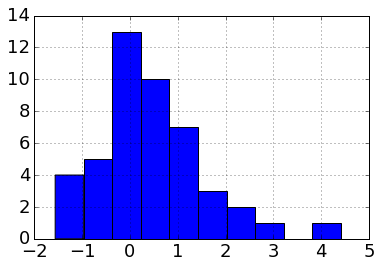

In [329]:
(UHI_resultsDF['Dry']- UHI_resultsDF['Moist']).loc[paired_df['Urban distance']< .25].hist()

In [331]:
(UHI_resultsDF['Dry']- UHI_resultsDF['Moist']).loc[paired_df['Urban distance']< .2].mean()

0.5213938644520113

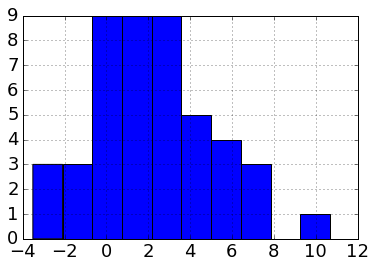

In [332]:
UHI_resultsDF['Dry'].hist()

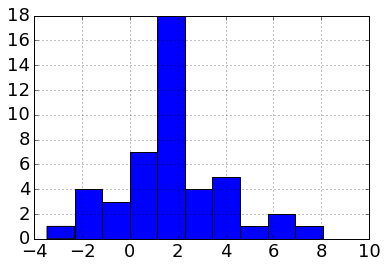

In [334]:
UHI_resultsDF['Moist'].hist()

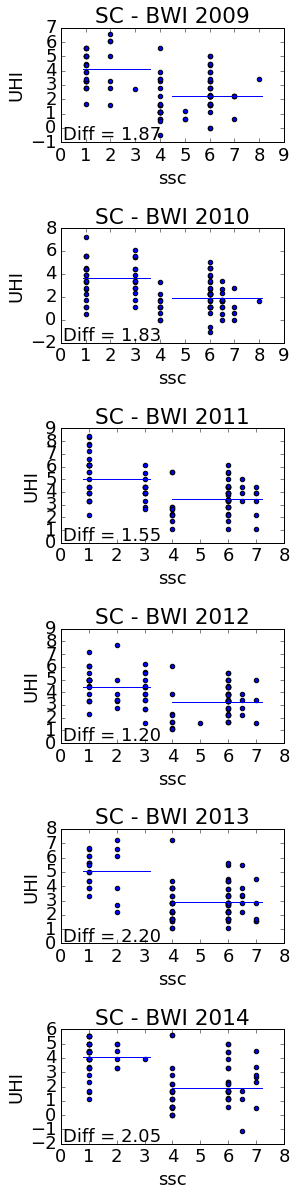

In [335]:
# replicate Darryn's Baltimore analysis for science center versus BWI
city = 'Baltimore'
ssc_code = stations[stations['Station'].str.contains(city)]['ID'].values
if city == 'Washington, D.C.': 
    ssc_code = np.array(['IAD'])
if ssc_code.shape[0] > 0: 
    file = filepath + ssc_code[0] + '.dbdmt'
    synopticDF =  pd.read_table(file, sep = ' ', header =  None)
    synopticDF.columns = ['id','date', 'ssc']
    synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
    synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
    synopticDF = synopticDF.loc['1985-06-01':]

    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data('USW00093721',#ruralID,
                                         as_dataframe=True, update = False)
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 

    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

    # clean data: eliminate min temperatures below 4 or above 35
    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer

rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

# # clean data: eliminate min temperatures below 4 or above 35
# rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
# urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#calculate UHI
UHI = urban_summer - rural_summer
# see if we can reproduce darryn's plots
UHI = urban_summer - rural_summer

fig, axes = plt.subplots(6,1, figsize = [4,20])
plt.subplots_adjust(hspace=0.75)
i = 0
for year in range(2009, 2015): 
    x = synopticDF['ssc']
    y = UHI['%s-06-01'%year:'%s-08-30'%year]
    x = x[y.index]
    axes[i].scatter(x, y)
    d =y[x<=3].mean() - y[x>3].mean()
    axes[i].axhline(y[x<=3].mean(), xmin = .1, xmax=.4)
    axes[i].axhline(y[(x>3) & (x<7)].mean(), xmin = .5, xmax=.9)
    axes[i].annotate('Diff = %2.2f'%d , xy = (0.01,0.02), xycoords = 'axes fraction')
    axes[i].set_xlabel('ssc')
    axes[i].set_ylabel('UHI')
    axes[i].set_title('SC - BWI %s'%( year))
    i = i+1